In [91]:
import pandas as pd


In [92]:
user_engagement_df = pd.read_csv("takehome_user_engagement.csv")
users_df = pd.read_csv("takehome_users.csv", encoding='latin-1')

In [95]:
print("User Engagement Data:")
print(user_engagement_df.head())
print("\nUsers Data:")
print(users_df.head())

User Engagement Data:
           time_stamp  user_id  visited
0 2014-04-22 03:53:30        1        1
1 2013-11-15 03:45:04        2        1
2 2013-11-29 03:45:04        2        1
3 2013-12-09 03:45:04        2        1
4 2013-12-25 03:45:04        2        1

Users Data:
   object_id       creation_time               name  \
0          1 2014-04-22 03:53:30     Clausen August   
1          2 2013-11-15 03:45:04      Poole Matthew   
2          3 2013-03-19 23:14:52  Bottrill Mitchell   
3          4 2013-05-21 08:09:28    Clausen Nicklas   
4          5 2013-01-17 10:14:20          Raw Grace   

                        email creation_source last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE        2014-04-22 03:53:30   
1      MatthewPoole@gustr.com      ORG_INVITE        2014-03-31 03:45:04   
2  MitchellBottrill@gustr.com      ORG_INVITE        2013-03-19 23:14:52   
3   NicklasSClausen@yahoo.com    GUEST_INVITE        2013-05-22 08:09:28   
4          Gra

In [94]:
# Convert date and timestamp columns to datetime objects
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])
user_engagement_df = user_engagement_df.sort_values(by=['user_id', 'time_stamp'])



In [96]:
def is_adopted_user(x):
    """ Function to check if a user is an adopted user """
    if len(x) >= 3:
        x = x.sort_values().reset_index(drop=True)
        for i in range(len(x) - 2):
            if (x[i + 2] - x[i]).days <= 7:
                return True
    return False

adopted = user_engagement_df.groupby('user_id')['time_stamp'].apply(is_adopted_user)
adopted = adopted.reset_index().rename(columns={'time_stamp': 'is_adopted'})

In [97]:
adopted.sum()

user_id       53112887
is_adopted        1656
dtype: int64

In [98]:
# Merge adopted user data
users_df = pd.merge(users_df, adopted, left_on='object_id', right_on='user_id', how='left')



In [99]:
# Fill NA values for 'is_adopted'
users_df['is_adopted'] = users_df['is_adopted'].fillna(False)

# Handle other missing values as per requirement (example shown for invited_by_user_id)
users_df['invited_by_user_id'] = users_df['invited_by_user_id'].fillna(0)

# For categorical data like 'creation_source', you can use one-hot encoding
users_df = pd.get_dummies(users_df, columns=['creation_source'])
print(users_df.head())

   object_id       creation_time               name  \
0          1 2014-04-22 03:53:30     Clausen August   
1          2 2013-11-15 03:45:04      Poole Matthew   
2          3 2013-03-19 23:14:52  Bottrill Mitchell   
3          4 2013-05-21 08:09:28    Clausen Nicklas   
4          5 2013-01-17 10:14:20          Raw Grace   

                        email last_session_creation_time  \
0    AugustCClausen@yahoo.com        2014-04-22 03:53:30   
1      MatthewPoole@gustr.com        2014-03-31 03:45:04   
2  MitchellBottrill@gustr.com        2013-03-19 23:14:52   
3   NicklasSClausen@yahoo.com        2013-05-22 08:09:28   
4          GraceRaw@yahoo.com        2013-01-22 10:14:20   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2                         0                           0      94   
3                         0             

In [102]:
# Displaying basic information about the DataFrame
print(users_df.info())

# Descriptive statistics for numerical columns
print(users_df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   object_id                           12000 non-null  int64         
 1   creation_time                       12000 non-null  datetime64[ns]
 2   name                                12000 non-null  object        
 3   email                               12000 non-null  object        
 4   last_session_creation_time          8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list            12000 non-null  int64         
 6   enabled_for_marketing_drip          12000 non-null  int64         
 7   org_id                              12000 non-null  int64         
 8   invited_by_user_id                  12000 non-null  float64       
 9   user_id                             8823 non-null   float64       
 10  is_adopted            

In [103]:
# Count of users by creation source
print(users_df[['creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE', 
                'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP', 
                'creation_source_SIGNUP_GOOGLE_AUTH']].sum())

# Proportion of users who opted in to mailing list
print(users_df['opted_in_to_mailing_list'].value_counts(normalize=True))

# Proportion of users enabled for marketing drip
print(users_df['enabled_for_marketing_drip'].value_counts(normalize=True))


creation_source_GUEST_INVITE          2163
creation_source_ORG_INVITE            4254
creation_source_PERSONAL_PROJECTS     2111
creation_source_SIGNUP                2087
creation_source_SIGNUP_GOOGLE_AUTH    1385
dtype: int64
opted_in_to_mailing_list
0    0.7505
1    0.2495
Name: proportion, dtype: float64
enabled_for_marketing_drip
0    0.850667
1    0.149333
Name: proportion, dtype: float64


In [104]:
# Overall proportion of adopted users
print(users_df['is_adopted'].value_counts(normalize=True))

# Breakdown of adopted users by creation source
creation_sources = ['creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE', 
                    'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP', 
                    'creation_source_SIGNUP_GOOGLE_AUTH']

for source in creation_sources:
    print(users_df.groupby(source)['is_adopted'].value_counts(normalize=True))



is_adopted
False    0.862
True     0.138
Name: proportion, dtype: float64
creation_source_GUEST_INVITE  is_adopted
False                         False         0.869167
                              True          0.130833
True                          False         0.829404
                              True          0.170596
Name: proportion, dtype: float64
creation_source_ORG_INVITE  is_adopted
False                       False         0.860315
                            True          0.139685
True                        False         0.865068
                            True          0.134932
Name: proportion, dtype: float64
creation_source_PERSONAL_PROJECTS  is_adopted
False                              False         0.849934
                                   True          0.150066
True                               False         0.918522
                                   True          0.081478
Name: proportion, dtype: float64
creation_source_SIGNUP  is_adopted
False             

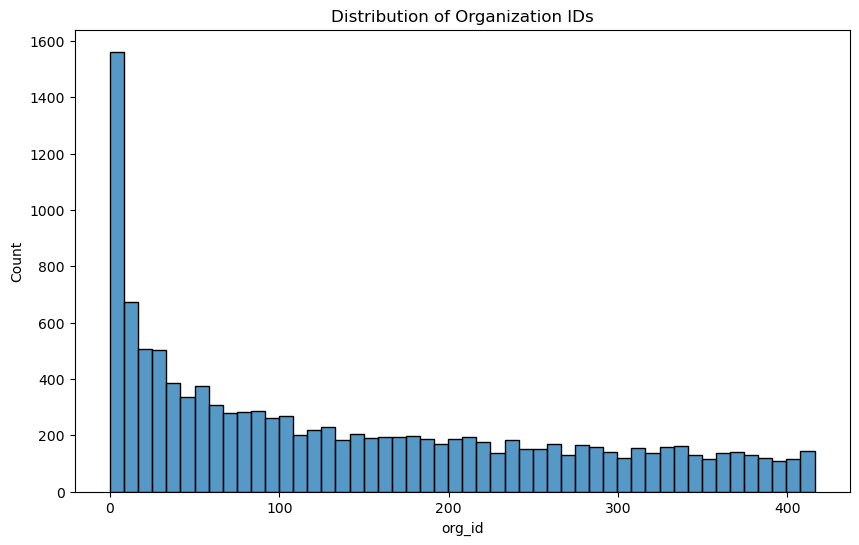

<Figure size 1000x600 with 0 Axes>

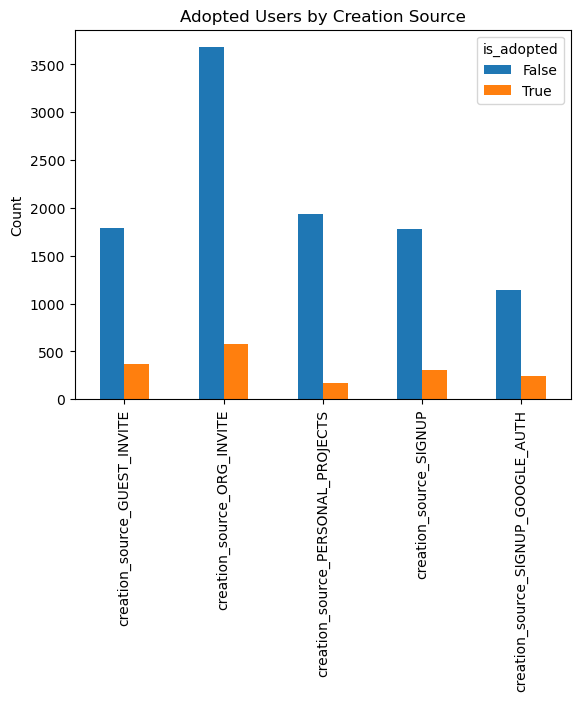

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of organization IDs
plt.figure(figsize=(10, 6))
sns.histplot(users_df['org_id'], bins=50, kde=False)
plt.title('Distribution of Organization IDs')
plt.show()

# Bar plot of adopted users by creation source
plt.figure(figsize=(10, 6))
users_df.groupby('is_adopted')[creation_sources].sum().T.plot(kind='bar')
plt.title('Adopted Users by Creation Source')
plt.ylabel('Count')
plt.show()



General Findings:
Creation Source Distribution: The majority of users signed up through 'ORG_INVITE' (4254 users), followed by 'GUEST_INVITE' (2163 users), 'PERSONAL_PROJECTS' (2111 users), 'SIGNUP' (2087 users), and 'SIGNUP_GOOGLE_AUTH' (1385 users). This distribution indicates that organizational invitations are the most common way users join the platform.

Mailing List and Marketing Drip Opt-ins: A significant majority of users (75.05%) have not opted in to the mailing list, and an even larger majority (85.07%) are not enabled for the marketing drip. This could suggest a general reluctance to receive marketing emails or that users prefer other forms of communication.

Analysis of Adopted Users:
Overall Proportion of Adopted Users: Only 13.8% of users are classified as adopted users, highlighting a relatively low overall user engagement level as defined by the criteria.

Summary and Recommendations:
The key driver of adoption appears to be the method of joining the platform, with personal invitations (especially as guests) being slightly more effective.
Low opt-in rates for mailing lists and marketing drips might indicate a need to explore other engagement strategies.
Users joining for personal projects are less likely to be highly engaged, suggesting a potential area for targeted engagement strategies.